In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
pkpd_times_np = np.array([0.0, 1.0, 2.0, 4.0, 8.0, 12.0, 24.0, 36.0, 48.0, 72.0, 168.0, 336.0, 480.0, 481.0, 482.0, 484.0, 488.0, 492.0, 504.0, 552.0, 600.0, 672.0, 840.0, 1008.0, 1176.0])

In [47]:
# -----------------------------
# example PK/PD MODEL DEFINITIONS
# -----------------------------
def one_comp_oral(t, y, ka, CL, V):
    """One-compartment oral absorption model."""
    A_gut, A_c = y
    dA_gut = -ka * A_gut
    dA_c = ka * A_gut - (CL / V) * A_c
    return [dA_gut, dA_c]
def two_comp_iv(t, y, CL, Vc, Vp, Q):
    """Two-compartment IV bolus model (linear elimination)."""
    A_c, A_p = y
    dA_c = -(CL / Vc) * A_c - Q/Vc * A_c + Q/Vp * A_p
    dA_p = Q/Vc * A_c - Q/Vp * A_p
    return [dA_c, dA_p]
def indirect_response(t, y, kin, kout, IC50, C):
    """Indirect response model where drug inhibits production."""
    R = y[0]  # biomarker response
    inhibition = C / (IC50 + C)  # inhibitory Emax model with Emax=1
    dR = kin * (1 - inhibition) - kout * R
    return [dR]
# -----------------------------
# SIMULATION FUNCTIONS
# -----------------------------
def simulate_one_comp(dose, ka, CL, V, times):
    y0 = [dose, 0.0]
    sol = solve_ivp(one_comp_oral, [times[0], times[-1]], y0,
                    t_eval=times, args=(ka, CL, V))
    conc = sol.y[1] / V
    return conc
def simulate_two_comp(dose, CL, Vc, Vp, Q, times):
    y0 = [dose, 0.0]
    sol = solve_ivp(two_comp_iv, [times[0], times[-1]], y0,
                    t_eval=times, args=(CL, Vc, Vp, Q))
    conc = sol.y[0] / Vc
    return conc
def simulate_indirect_one(dose, ka, CL, V, kin, kout, IC50, times):
    # First simulate PK using one-compartment oral model
    A_gut0, A_c0 = dose, 0.0
    pk_sol = solve_ivp(one_comp_oral, [times[0], times[-1]], [A_gut0, A_c0],
                       t_eval=times, args=(ka, CL, V))
    conc = pk_sol.y[1] / V
    # Then feed PK concentrations into indirect response model
    R0 = kin / kout  # baseline
    biomarker = [R0]
    for i in range(1, len(times)):
        tspan = [times[i-1], times[i]]
        sol = solve_ivp(indirect_response, tspan, [biomarker[-1]],
                        t_eval=[times[i]], args=(kin, kout, IC50, conc[i]))
        biomarker.append(sol.y[0, -1])
    return np.array(biomarker)

def simulate_indirect_two(dose, CL, Vc, Vp, Q, kin, kout, IC50, times):
    # First simulate PK using two-compartment model
    y0 = dose, 0.0
    pk_sol = solve_ivp(two_comp_iv, [times[0], times[-1]], y0,
                       t_eval=times, args=(CL, Vc, Vp, Q))
    conc = pk_sol.y[0] / Vc
    # Then feed PK concentrations into indirect response model
    R0 = kin / kout  # baseline
    biomarker = [R0]
    for i in range(1, len(times)):
        tspan = [times[i-1], times[i]]
        sol = solve_ivp(indirect_response, tspan, [biomarker[-1]],
                        t_eval=[times[i]], args=(kin, kout, IC50, conc[i]))
        biomarker.append(sol.y[0, -1])
    return np.array(biomarker)
# -----------------------------
# NOISE & VARIABILITY
# -----------------------------
def add_noise(conc, sigma=0.1, add_err=0.05):
    """
    Add combined proportional + additive error.
    sigma : proportional error (CV%)
    add_err : additive error
    """
    noise = np.random.normal(0, add_err, size=conc.shape)
    return conc + noise
def apply_iiv(param, omega=0.2):
    """Apply inter-individual variability (log-normal)."""
    return param * np.exp(np.random.normal(0, omega))

# values have to be positive
def make_positive(conc):
  if np.min(conc)<0:
    return conc - np.min(conc)
  else:
    return conc
# -----------------------------
# SYNTHETIC DATA GENERATOR
# -----------------------------
def generate_synthetic_dataset(N, model_classes, dose, times=np.array([0.5,1,2,4,6,8,12,24])):
    dataset = []
    for i in range(N):
        # Randomly choose model type
        model_type = np.random.choice(model_classes)

        if model_type == "one_comp":
            # Sample parameters
            ka = apply_iiv(np.random.uniform(0.5, 2.0))
            CL = apply_iiv(np.random.uniform(5.0, 20.0))
            V = apply_iiv(np.random.uniform(20.0, 50.0))
            dose = dose
            conc = simulate_one_comp(dose, ka, CL, V, times)
            conc_noisy = add_noise(conc)
            conc_noisy = make_positive(conc_noisy)
            dataset.append({"id": i, "model": "one_comp", "times": times, "dose" : dose,
                            "concentration": conc_noisy, "params": {"ka": ka, "CL": CL, "V": V}})

        elif model_type == "two_comp":
            CL = apply_iiv(np.random.uniform(5.0, 20.0))
            Vc = apply_iiv(np.random.uniform(10.0, 30.0))
            Vp = apply_iiv(np.random.uniform(20.0, 60.0))
            Q = apply_iiv(np.random.uniform(2.0, 10.0))
            dose = dose
            conc = simulate_two_comp(dose, CL, Vc, Vp, Q, times)
            conc_noisy = add_noise(conc)
            conc_noisy = make_positive(conc_noisy)
            dataset.append({"id": i, "model": "two_comp", "times": times, "dose" : dose,
                            "concentration": conc_noisy, "params": {"CL": CL, "Vc": Vc, "Vp": Vp, "Q": Q}})

        elif model_type == "indirect-one":
            ka = apply_iiv(np.random.uniform(0.5, 2.0))
            CL = apply_iiv(np.random.uniform(5.0, 15.0))
            V = apply_iiv(np.random.uniform(20.0, 40.0))
            kin = apply_iiv(np.random.uniform(0.5, 1.5))
            kout = apply_iiv(np.random.uniform(0.2, 0.8))
            IC50 = np.random.uniform(1.0, 5.0)
            dose = dose
            biomarker = simulate_indirect_one(dose, ka, CL, V, kin, kout, IC50, times)
            biomarker_noisy = add_noise(biomarker)
            biomarker_noisy = make_positive(biomarker_noisy)
            dataset.append({"id": i, "model": "indirect-one", "times": times, "dose" : dose,
                            "response": biomarker_noisy, "params": {"ka": ka, "CL": CL, "V": V,
                                                                     "kin": kin, "kout": kout, "IC50": IC50}})

        elif model_type == "indirect-two":
            CL = apply_iiv(np.random.uniform(5.0, 20.0))
            Vc = apply_iiv(np.random.uniform(10.0, 30.0))
            Vp = apply_iiv(np.random.uniform(20.0, 60.0))
            Q = apply_iiv(np.random.uniform(2.0, 10.0))
            kin = apply_iiv(np.random.uniform(0.5, 1.5))
            kout = apply_iiv(np.random.uniform(0.2, 0.8))
            IC50 = np.random.uniform(1.0, 5.0)
            dose = dose
            biomarker = simulate_indirect_two(dose, CL, Vc, Vp, Q, kin, kout, IC50, times)
            biomarker_noisy = add_noise(biomarker)
            biomarker_noisy = make_positive(biomarker_noisy)
            dataset.append({"id": i, "model": "indirect-two", "times": times, "dose" : dose,
                            "response": biomarker_noisy, "params": {"CL": CL, "Vc": Vc, "Vp": Vp, "Q": Q,
                                                                     "kin": kin, "kout": kout, "IC50": IC50}})

    return dataset

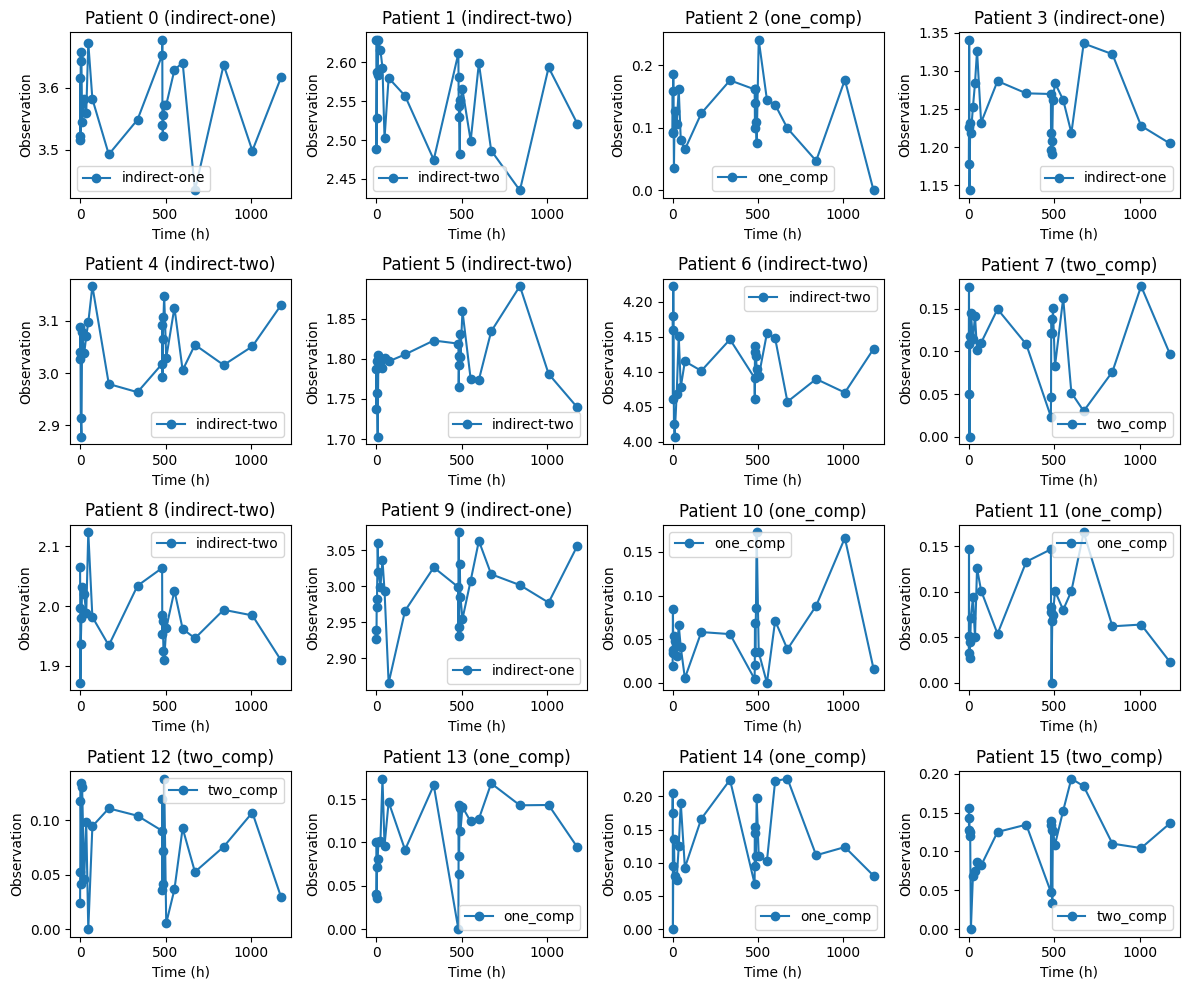

In [48]:
# -----------------------------
# EXAMPLE USAGE
# -----------------------------
np.random.seed(123)
synthetic_data = []
# we create dataset for the two models that gives biomarker levels
for i in range(1, 16):
   synthetic_data.extend(generate_synthetic_dataset(N=500, model_classes = ["one_comp", "two_comp", "indirect-one", "indirect-two"], dose=i, times=pkpd_times_np))
# Plot
fig, axes = plt.subplots(4, 4, figsize=(12,10))
axes = axes.flatten()
for i, patient in enumerate(synthetic_data[:16]):
    ax = axes[i]
    if patient["model"] in ["one_comp", "two_comp"]:
        ax.plot(patient["times"], patient["concentration"], 'o-', label=patient["model"])
    else:
        ax.plot(patient["times"], patient["response"], 'o-', label=patient["model"])
    ax.set_title(f"Patient {patient['id']} ({patient['model']})")
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Observation")
    ax.legend()
plt.tight_layout()
plt.show()

In [55]:
synthetic_data[1]

{'id': 1,
 'model': 'indirect-two',
 'times': array([0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 1.200e+01,
        2.400e+01, 3.600e+01, 4.800e+01, 7.200e+01, 1.680e+02, 3.360e+02,
        4.800e+02, 4.810e+02, 4.820e+02, 4.840e+02, 4.880e+02, 4.920e+02,
        5.040e+02, 5.520e+02, 6.000e+02, 6.720e+02, 8.400e+02, 1.008e+03,
        1.176e+03]),
 'dose': 1,
 'response': array([2.62876706, 2.48859678, 2.52894752, 2.58758751, 2.58420525,
        2.62858524, 2.61536354, 2.59318674, 2.50220501, 2.57977478,
        2.55680351, 2.4746685 , 2.61137715, 2.58137648, 2.5435555 ,
        2.52984235, 2.48165787, 2.55155693, 2.56499485, 2.499024  ,
        2.59867021, 2.48651936, 2.43517252, 2.59329111, 2.52104214]),
 'params': {'CL': np.float64(10.378446611187945),
  'Vc': np.float64(22.051533444021512),
  'Vp': np.float64(95.88448335443906),
  'Q': np.float64(3.2202833604879886),
  'kin': np.float64(1.6131214227296713),
  'kout': np.float64(0.6346920038837743),
  'IC50': 2.216483156

In [146]:
# creating numpy dataset from synthetic data for training
X_np = np.zeros((len(synthetic_data),25))
y_class_np = np.zeros((len(synthetic_data)))
y_reg_np = np.zeros((len(synthetic_data),9))

def parameter_vector_creator(parameter_dict):
  keys = ["ka", "CL", "V", "Vc", "Vp", "Q", "kin", "kout", "IC50"]
  result = []
  for key in keys:
    item = parameter_dict.get(key)
    if item==None:
      result.append(0)
    else:
      result.append(item)

  return np.array(result)

for i in range(len(synthetic_data)):
  entry = synthetic_data[i]
  if entry['model']=='one_comp':
    X_np[i] = entry['concentration']
    y_class_np[i] = 0
    y_reg_np[i] = parameter_vector_creator(entry['params'])
  elif entry['model']=='two_comp':
    X_np[i] = entry['concentration']
    y_class_np[i] = 1
    y_reg_np[i] = parameter_vector_creator(entry['params'])
  elif entry['model']=='indirect-one':
    X_np[i] = entry['response']
    y_class_np[i] = 2
    y_reg_np[i] = parameter_vector_creator(entry['params'])
  elif entry['model']=='indirect-two':
    X_np[i] = entry['response']
    y_class_np[i] = 3
    y_reg_np[i] = parameter_vector_creator(entry['params'])


In [147]:
X_np = np.expand_dims(X_np, axis=2)

In [148]:
print(X_np.shape)
print(y_class_np.shape)
print(y_reg_np.shape)

(7500, 25, 1)
(7500,)
(7500, 9)


In [149]:
print(X_np[:4])
print(y_class_np[:4])
print(y_reg_np[:4])

[[[3.52253144]
  [3.61538476]
  [3.5162419 ]
  [3.6579703 ]
  [3.64364752]
  [3.54493303]
  [3.58185601]
  [3.55882091]
  [3.67254823]
  [3.58193795]
  [3.49238258]
  [3.54844868]
  [3.65263231]
  [3.67746489]
  [3.53915454]
  [3.52182164]
  [3.55649622]
  [3.57146688]
  [3.57239603]
  [3.62882201]
  [3.64077345]
  [3.43419497]
  [3.63713473]
  [3.49837382]
  [3.61682019]]

 [[2.62876706]
  [2.48859678]
  [2.52894752]
  [2.58758751]
  [2.58420525]
  [2.62858524]
  [2.61536354]
  [2.59318674]
  [2.50220501]
  [2.57977478]
  [2.55680351]
  [2.4746685 ]
  [2.61137715]
  [2.58137648]
  [2.5435555 ]
  [2.52984235]
  [2.48165787]
  [2.55155693]
  [2.56499485]
  [2.499024  ]
  [2.59867021]
  [2.48651936]
  [2.43517252]
  [2.59329111]
  [2.52104214]]

 [[0.09198787]
  [0.15900688]
  [0.09287617]
  [0.1854024 ]
  [0.03545991]
  [0.12734094]
  [0.10579399]
  [0.16137093]
  [0.08033316]
  [0.06539721]
  [0.12312536]
  [0.17585963]
  [0.16135847]
  [0.13997955]
  [0.09947783]
  [0.16271378]
  [0.1

In [150]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MultiLabelTensorDataset(Dataset):
    def __init__(self, X_np, y_class_np, y_reg_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y_class = torch.tensor(y_class_np, dtype=torch.long)             # shape: (N,)
        self.y_reg = torch.tensor(y_reg_np, dtype=torch.float32)              # shape: (N, reg_dim)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_class[idx], self.y_reg[idx]


# Build the Dataset
synthetic_dataset = MultiLabelTensorDataset(X_np, y_class_np, y_reg_np)

# Example usage:
x, y_class, y_reg = synthetic_dataset[0]
print("x:", x.shape)
print("y_class:", y_class.shape)
print("y_reg:", y_reg.shape)


x: torch.Size([25, 1])
y_class: torch.Size([])
y_reg: torch.Size([9])


In [151]:
# use DataLoader to train using batches
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=16, shuffle=True)
batch = next(iter(synthetic_dataloader))
x, y_class, y_reg = batch
print(x.shape)
print(y_class.shape)
print(y_reg.shape)

torch.Size([16, 25, 1])
torch.Size([16])
torch.Size([16, 9])


In [152]:
#x
y_class
#y_reg

tensor([1, 2, 0, 3, 0, 1, 3, 2, 3, 0, 2, 0, 0, 2, 2, 3])

In [153]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# this model inputs a sequential data and gets a fixed vector representation
# using that vector it uses two separate networks
# one that predicts the model
# another that predicts the parameter values
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, hidden_dim, num_models, max_num_params, dim_feedforward=128, dropout=0.1, max_len=100):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.d_model = d_model
        # using the encoded vector we make predictions about the model and the parameter vector

        self.model_predictor = nn.Sequential(
                nn.Linear(d_model, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_models),
        )
        self.parameter_predictor = nn.Sequential(
                nn.Linear(d_model, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, max_num_params),
        )


    def forward(self, src, src_key_padding_mask=None):
        src = self.input_linear(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        # only take first vector of the output [:,0,:]
        model_class = self.model_predictor(output[:,0,:])
        parameter_vector = self.parameter_predictor(output[:,0,:])
        return model_class, parameter_vector

# Example: collate a batch of variable length sequences
def collate_batch(batch, pad_value=0):
    # batch: list of (tensor, target) pairs
    xs, ys = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    # Pad sequences
    xs_padded = [torch.nn.functional.pad(x, (0,0,0,max_len-x.shape[0]), value=pad_value) for x in xs]
    xs_padded = torch.stack(xs_padded) # (batch_size, max_len, input_dim)
    # Create src_key_padding_mask: True for PAD, False for valid
    mask = torch.zeros((len(xs), max_len), dtype=torch.bool)
    for i, l in enumerate(lengths):
        if l < max_len:
            mask[i, l:] = True
    ys_padded = [torch.nn.functional.pad(y, (0,max_len-y.shape[0]), value=pad_value) for y in ys]
    ys_padded = torch.stack(ys_padded)
    return xs_padded, ys_padded, mask


In [154]:
# currently the input dimension is 1, but if we include data such as dose AMT as the sequential input data we can extend it further
model = TransformerEncoderModel(input_dim=1, d_model=32, nhead=4, num_layers=6, hidden_dim=64, num_models=4, max_num_params=9, dim_feedforward=128, dropout=0.1, max_len=100)

In [155]:
batch = next(iter(synthetic_dataloader))
x, y_class, y_reg = batch
print(x.shape)
print(y_class.shape)
print(y_reg.shape)

output = model(x)
print(output[0].shape)
print(output[0])
print(output[1].shape)
print(output[1])

torch.Size([16, 25, 1])
torch.Size([16])
torch.Size([16, 9])
torch.Size([16, 4])
tensor([[ 0.2614,  0.2595,  0.1240,  0.3294],
        [-0.2975,  0.1503,  0.5093,  0.1385],
        [ 0.0099,  0.2255,  0.5442,  0.1498],
        [-0.2417,  0.2031,  0.4991,  0.1396],
        [ 0.1798,  0.0960,  0.2879,  0.1305],
        [-0.3550,  0.2056,  0.5366,  0.0399],
        [ 0.3652,  0.2729,  0.3126,  0.1963],
        [ 0.0766,  0.1148,  0.2503,  0.2315],
        [ 0.3212,  0.1609,  0.3505,  0.2029],
        [-0.2948,  0.2109,  0.4776,  0.0594],
        [ 0.4361,  0.1854,  0.3108,  0.1047],
        [ 0.4529,  0.2179,  0.1964,  0.1913],
        [-0.3104,  0.1819,  0.3971,  0.1579],
        [ 0.3557,  0.1479,  0.3791,  0.2116],
        [ 0.4057,  0.1678,  0.2951,  0.0706],
        [ 0.3589,  0.2549,  0.2168,  0.2549]], grad_fn=<AddmmBackward0>)
torch.Size([16, 9])
tensor([[-0.1937, -0.1883,  0.0753,  0.1567, -0.0540, -0.0269,  0.2486, -0.3603,
          0.6154],
        [ 0.0198, -0.1983,  0.4532, 

In [159]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import random_split

def train(model, dataset, batch_size, lr, gamma, num_epochs):
  # we use two losses
  # first loss is the categorical loss for the model classification
  # second loss is the MSELoss for the parameter space
  # Iterating over the dataloader yields batches:
  train_size = int(0.9 * len(dataset))
  valid_size = len(dataset) - train_size

  # Randomly split dataset
  train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

  batch = next(iter(train_loader))
  batch_x, batch_y_class, batch_y_reg = batch

  optimizer = optim.Adam(model.parameters(), lr=lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=gamma)  # LR decays every 10 epochs
  criterion_class = nn.CrossEntropyLoss()
  criterion_reg = nn.MSELoss()

  train_losses = []
  valid_losses = []
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y_class, batch_y_reg in train_loader:
      optimizer.zero_grad()
      outputs_class, outputs_reg = model(batch_x)
      loss_cls = criterion_class(outputs_class, batch_y_class)
      loss_reg = criterion_reg(outputs_reg, batch_y_reg)
      loss = loss_cls + loss_reg
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * batch_x.size(0)
    scheduler.step()  # update LR after each epoch
    with torch.no_grad():
      vbatch_x, vbatch_y_class, vbatch_y_reg = next(iter(valid_loader))
      voutputs_class, voutputs_reg = model(vbatch_x)
      vloss_cls = criterion_class(voutputs_class, vbatch_y_class)
      vloss_reg = criterion_reg(voutputs_reg, vbatch_y_reg)
      vloss = vloss_cls + vloss_reg

    avg_loss = total_loss / len(train_dataset)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")
    train_losses.append(avg_loss)
    valid_losses.append(vloss.item())

  return train_losses, valid_losses

In [160]:
# separate dataset further into train, test data
train_n = int(X_np.shape[0]*0.9)

train_dataset = MultiLabelTensorDataset(X_np[:train_n], y_class_np[:train_n], y_reg_np[:train_n])
test_dataset = MultiLabelTensorDataset(X_np[train_n:], y_class_np[train_n:], y_reg_np[train_n:])

print(len(train_dataset))
print(len(test_dataset))

6750
750


In [161]:
# define and train model
model = TransformerEncoderModel(input_dim=1, d_model=32, nhead=4, num_layers=6, hidden_dim=64, num_models=4, max_num_params=9, dim_feedforward=128, dropout=0.1, max_len=100)
train_loss, valid_loss = train(model, train_dataset, batch_size=16, lr=2e-4, gamma=0.99, num_epochs=100)

Epoch 1/100, Average Loss: 173.8959, LR: 0.000200
Epoch 2/100, Average Loss: 111.8017, LR: 0.000200
Epoch 3/100, Average Loss: 91.8852, LR: 0.000200
Epoch 4/100, Average Loss: 80.1411, LR: 0.000200
Epoch 5/100, Average Loss: 77.2451, LR: 0.000200
Epoch 6/100, Average Loss: 77.4750, LR: 0.000200
Epoch 7/100, Average Loss: 76.4235, LR: 0.000200
Epoch 8/100, Average Loss: 76.0081, LR: 0.000200
Epoch 9/100, Average Loss: 76.0248, LR: 0.000200
Epoch 10/100, Average Loss: 76.2031, LR: 0.000198
Epoch 11/100, Average Loss: 76.1644, LR: 0.000198
Epoch 12/100, Average Loss: 75.5631, LR: 0.000198
Epoch 13/100, Average Loss: 75.5641, LR: 0.000198
Epoch 14/100, Average Loss: 75.4968, LR: 0.000198
Epoch 15/100, Average Loss: 75.4296, LR: 0.000198
Epoch 16/100, Average Loss: 74.8314, LR: 0.000198
Epoch 17/100, Average Loss: 75.1516, LR: 0.000198
Epoch 18/100, Average Loss: 74.8055, LR: 0.000198
Epoch 19/100, Average Loss: 75.0589, LR: 0.000198
Epoch 20/100, Average Loss: 75.0318, LR: 0.000196
Epoch 2

Text(0, 0.5, 'Loss')

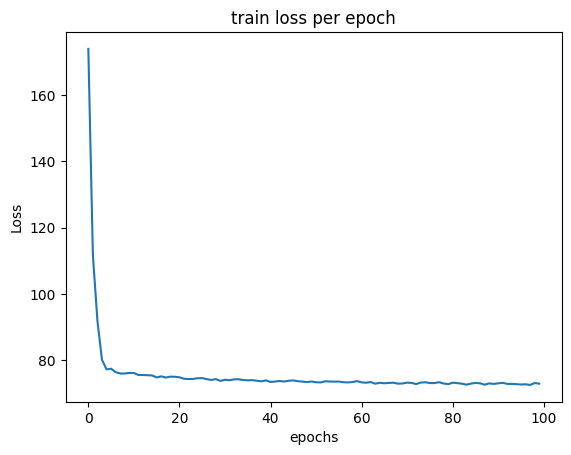

In [163]:
plt.plot(train_loss)
plt.title("train loss per epoch")
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

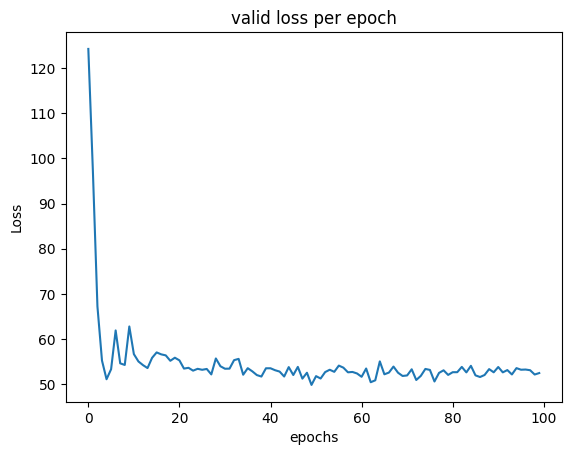

In [164]:
plt.plot(valid_loss)
plt.title("valid loss per epoch")
plt.xlabel("epochs")
plt.ylabel("Loss")

In [166]:
# test using test dataset
total_correct = 0
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
for batch_x, batch_y_class, batch_y_reg in test_loader:
  outputs_class, outputs_reg = model(batch_x)
  pred_classes = torch.argmax(outputs_class, dim=1)
  correct = (pred_classes == batch_y_class).sum().item()
  total_correct+=correct

model_classification_accuracy = total_correct/len(test_dataset)
print("accuracy of model: ", model_classification_accuracy*100, "%")

accuracy of model:  76.93333333333334 %


In [173]:
# obtain the time series of our dataset
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/MyDrive/QIC/QIC2025-EstDat.csv')
column_arrays = []
for key in df.keys():
  column_arrays.append(df[key].to_numpy())

individuals = []

for i in range(48):
  individuals.append([])

for i in range(len(column_arrays[0])):
  individuals[column_arrays[0][i]-1].append(np.array([column_arrays[1][i],column_arrays[2][i],column_arrays[3][i],column_arrays[4][i],column_arrays[5][i],column_arrays[6][i],column_arrays[7][i],column_arrays[8][i],column_arrays[9][i],column_arrays[10][i]]))

individual_data = []
for individual in individuals:
  individual_data.append(np.vstack(individual))

individual_data_wo_mdv = []

for i in range(len(individual_data)):
  before = individual_data[i]
  after = []
  for j in range(len(before)):
    if before[j][6]==1:
      pass
    else:
      after.append(np.concat([before[j][:6],before[j][7:]]))
  individual_data_wo_mdv.append(np.vstack(after))


individual_data_wo_mdv_biomarker = []
individual_data_wo_mdv_concentration = []

for i in range(len(individual_data_wo_mdv)):
  before = individual_data_wo_mdv[i]
  after_b = []
  after_c = []
  for j in range(len(before)):
    if before[j][-1]==2:
      after_b.append(before[j][:8])
    elif before[j][-1]==1:
      after_c.append(before[j][:8])
    else:
      pass
  if after_b != []:
    individual_data_wo_mdv_biomarker.append(np.vstack(after_b))
  if after_c != []:
    individual_data_wo_mdv_concentration.append(np.vstack(after_c))

dosed_time_series_bio = np.zeros((36,25))
dosed_time_series_con = np.zeros((36,24))
for i in range(12,48):
  dosed_time_series_bio[i-12] = individual_data_wo_mdv_biomarker[i][:, 4]
for i in range(0,36):
  dosed_time_series_con[i] = individual_data_wo_mdv_concentration[i][:, 4]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [174]:
dosed_time_series_bio = np.expand_dims(dosed_time_series_bio, axis=2)
dosed_time_series_con = np.expand_dims(dosed_time_series_con, axis=2)
dosed_time_series_bio_tensor = torch.tensor(dosed_time_series_bio, dtype=torch.float32)
dosed_time_series_con_tensor = torch.tensor(dosed_time_series_con, dtype=torch.float32)

In [175]:
# use it to predict the model classes and parameter values
bio_class_output, bio_param_output = model(dosed_time_series_bio_tensor)

In [176]:
con_class_output, con_param_output = model(dosed_time_series_con_tensor)

In [208]:
def result_printer(class_result, param_result):
  # each are size (batch, num_class) and (batch, num_param)
  class_index = torch.argmax(class_result, dim=1)
  class_stats = np.zeros(4)
  for i in range(param_result.shape[0]):
    if class_index[i]==0:
      print("class: one_comp, params: ka: ", param_result[i][0].item(), "CL: ", param_result[i][1].item(), "V: ", param_result[i][2].item())
      class_stats[0]+=1
    elif class_index[i]==1:
      print("class: two_comp, params: CL: ", param_result[i][1].item(), "Vc: ", param_result[i][3].item(), "Vp: ", param_result[i][4].item(), "Q: ", param_result[i][5].item())
      class_stats[1]+=1
    elif class_index[i]==2:
      print("class: indirect-one, params: ka: ", param_result[i][0].item(), "CL: ", param_result[i][1].item(), "V: ", param_result[i][2].item(), "kin: ",param_result[i][6].item(), "kout: ", param_result[i][7].item(), "IC50", param_result[i][8].item())
      class_stats[2]+=1
    elif class_index[i]==3:
      print("class: indirect-two, params: CL: ", param_result[i][1].item(), "Vc: ", param_result[i][3].item(), "Vp: ", param_result[i][4].item(), "Q: ", param_result[i][5].item(), "kin: ", param_result[i][6].item(), "kout: ", param_result[i][7].item(), "IC50: ", param_result[i][8].item())
      class_stats[3]+=1
  print(class_stats)

In [209]:
result_printer(bio_class_output, bio_param_output)

class: indirect-two, params: CL:  11.61507797241211 Vc:  9.864582061767578 Vp:  20.016298294067383 Q:  3.0561916828155518 kin:  1.2051184177398682 kout:  0.45984190702438354 IC50:  3.2574234008789062
class: indirect-one, params: ka:  0.5653338432312012 CL:  11.438082695007324 V:  14.589614868164062 kin:  1.0851126909255981 kout:  0.4544593095779419 IC50 3.0988857746124268
class: indirect-one, params: ka:  0.5897525548934937 CL:  11.588346481323242 V:  14.882953643798828 kin:  1.1116738319396973 kout:  0.4816182553768158 IC50 3.1449897289276123
class: indirect-one, params: ka:  0.5986658930778503 CL:  11.860058784484863 V:  15.549822807312012 kin:  1.0943673849105835 kout:  0.4914046823978424 IC50 3.137099504470825
class: indirect-two, params: CL:  11.546921730041504 Vc:  10.159282684326172 Vp:  20.068058013916016 Q:  3.1489744186401367 kin:  1.1135557889938354 kout:  0.4775438904762268 IC50:  3.148707628250122
class: indirect-one, params: ka:  0.5894646048545837 CL:  11.688573837280273

In [ ]:
# the indirect-one model describes our biomarker model the best

In [195]:
# plot the two results
individual_data_wo_mdv_biomarker[12][:,2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [198]:
dose = 1
CL=11.61507797241211
Vc=9.864582061767578
Vp=20.016298294067383
Q=3.0561916828155518
kin=1.2051184177398682
kout=0.45984190702438354
IC50=3.2574234008789062

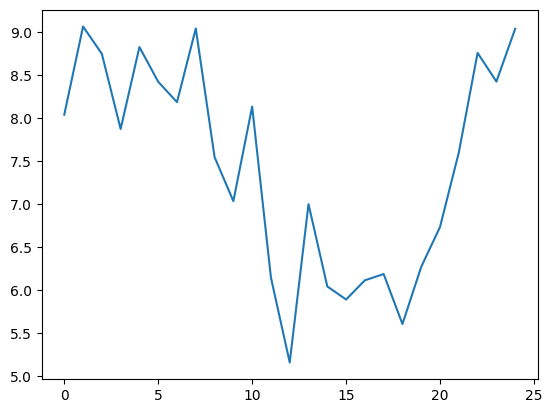

In [201]:
plt.plot(dosed_time_series_bio[0])

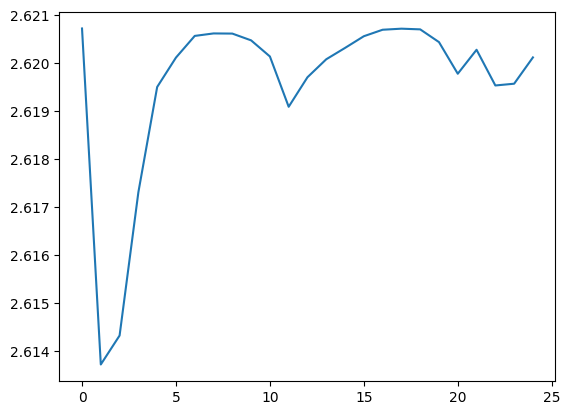

In [205]:
plt.plot(simulate_indirect_two(1, CL, Vc, Vp, Q, kin, kout, IC50, pkpd_times_np))

In [191]:
result_printer(con_class_output, con_param_output)

class: indirect-two, params: CL:  11.179917335510254 Vc:  7.410060405731201 Vp:  14.703608512878418 Q:  2.3960649967193604 kin:  0.9152000546455383 kout:  0.571014940738678 IC50:  3.0165791511535645
class: indirect-two, params: CL:  10.791325569152832 Vc:  7.11033821105957 Vp:  13.951358795166016 Q:  2.236722230911255 kin:  0.9556835889816284 kout:  0.42118433117866516 IC50:  2.8119401931762695
class: indirect-two, params: CL:  11.425559043884277 Vc:  9.17284870147705 Vp:  18.11979866027832 Q:  2.907222032546997 kin:  1.0806058645248413 kout:  0.4709613621234894 IC50:  3.1182990074157715
class: indirect-two, params: CL:  11.244606971740723 Vc:  7.811681270599365 Vp:  15.144418716430664 Q:  2.473483085632324 kin:  0.8761919140815735 kout:  0.4835514724254608 IC50:  2.873150587081909
class: indirect-two, params: CL:  11.470803260803223 Vc:  8.697087287902832 Vp:  16.969865798950195 Q:  2.756112575531006 kin:  0.9154180288314819 kout:  0.5798827409744263 IC50:  3.0465002059936523
class: i

In [ ]:
# further improvement to the model
# add more model classes
# make the dose AMT a time dependent variable so that it can be input with the sequential DV into our TransformerEncoder model for better training and prediction
# more hyperparameter tuning for the training